# Getting all grants received by a list of researchers 

Outline 

1. We start from a list of Dimensions Researcher identifiers e.g. `ur.01117731572.33`
2. We extract all Grants linked to these researchers 
3. We analyse the data quickly 

For more background information, see

* The [grants data model](https://docs.dimensions.ai/dsl/datasource-grants.html)
* The [researchers data model](https://docs.dimensions.ai/dsl/datasource-researchers.html#)
* The [Working with lists in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html) tutorial.


In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Feb 21, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the [API LAB](https://api-lab.dimensions.ai/) *Getting Started* tutorials.


In [2]:
!pip install dimcli plotly --quiet 

import dimcli
from dimcli.utils import *
import json
import sys
import pandas as pd

import plotly_express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")

ENDPOINT = "https://app.dimensions.ai"

if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login()

dsl = dimcli.Dsl()

Searching config file credentials for default 'live' instance..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl/v2> - DSL v2.0
Method: dsl.ini file


## 1. Starting point: a list of researchers 

We can use a sample list of researchers data cointained in the [nih_researchers_information.csv](http://api-sample-data.dimensions.ai/data/nih_researchers_information.csv) file. 

This dataset includes 1000 rows, each providing various information about a single researcher, as well as their Dimensions identifier (column: `id`). 



In [3]:
FILE = "http://api-sample-data.dimensions.ai/data/nih_researchers_information.csv"
res_list = pd.read_csv(FILE)
res_list.head(20)

,first_name,id,last_name,nih_ppid,orcid_id
0,David,ur.01117731572.33,Heimbrook,"['14267998', '14368683', '10999002']",NaN
1,Jon C,ur.0672250117.33,Mirsalis,"['11173827', '14433388', '3313267', '14595725'...",NaN
2,David L,ur.01307632442.48,Woodland,['1881629'],NaN
3,Larry O,ur.0634201432.39,Arthur,['9684702'],NaN
4,Norman Miles,ur.015317756777.34,Kneteman,"['14729052', '9449843']",NaN
5,David J,ur.0750414726.09,Stewart,['7039607'],NaN
6,Timothy T,ur.0735157212.99,Stedman,"['2087566', '15971663', '15497203', '77852789'...",['0000-0002-5847-7931']
7,Andrew D,ur.01141323346.36,Robertson,['1892862'],NaN
8,Darby J S,ur.014147012027.56,Thompson,['7756471'],NaN
9,William Charles,ur.01275064132.37,Nierman,"['12063175', '12063203', '12063191', '12063197...",NaN


## 2. What Grants have been received by these researchers? 

It's worth revisiting the [Dimensions data model](https://docs.dimensions.ai/dsl/_images/data-model-grants.png) for researchers: 

In [4]:
from IPython.display import Image
Image(url= "https://docs.dimensions.ai/dsl/_images/data-model-grants.png", width=600)

We are going to use the `researchers` link in order to extract all relevant grants. THe API query looks like this

```
search grants
          where researchers in [ *list of researchers*]
       return grants
```

Since we are using the query above to extract linked grants for hundreds of researchers there are a few more things to keep in mind (see also: [Working with lists in the Dimensions API](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#3.-Making-a-list-from-the-results-of-a-query):

* Limiting the Researchers IDs per query. In general, the API can handle up to 300-400 IDs per query. This is number isn’t set in stone though, but rather it should fine-tuned by trial and error, also considering the impact of the following points.
* Use Dimcli to pull grants data iteratively. We can use the [dimcli.query_iterative](https://digital-science.github.io/dimensions-api-lab/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html#Iterative-querying-(loops)) method to automatically retrieve grants records in batches of 1000.
* Dedup the final results. Since we are running the extraction using separate batches, it's very likely that might get duplicate grants (e.g. cause two or more researchers are associated to the same grants) - hence it's a good idea to remove duplicates before moving ahead.  

**WARNING**: the section below will take a few minutes to complete. To speed it up, uncomment the line that reduces the number of reaserchers to 200. 

In [5]:
# we get grants for all researchers, by segmenting the researchers list into groups of 300 IDs
# this is because each DSL query can take max ~300 researchers at a time 

from tqdm.notebook import tqdm as progressbar
researcher_ids = res_list['id'].to_list()

#
# TRIAL RUN: Uncomment this line to use less researchers and speed things up
#
# researcher_ids= researcher_ids[:200]


#
# the main API query
#
q = """search grants
          where researchers in {}
       return grants[id+title+active_year+research_org_names+research_org_countries+funding_usd+funding_org_name]"""


#
# let's loop through all researcher IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(researcher_ids), 200))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=True)
    results += data.grants
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
grants = pd.DataFrame().from_dict(results)
print("Grants: ", len(grants))
grants.drop_duplicates(subset='id', inplace=True)
print("Unique Grants: ", len(grants))
# # turning lists into strings to ensure compatibility with CSV loaded data
# # see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
# pubs['supporting_grant_ids'] = pubs['supporting_grant_ids'].apply(lambda x: ','.join(map(str, x)))

#
# preview
#
print("Example:")
grants.head(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 8993 (1.26s)
1000-2000 / 8993 (2.25s)
2000-3000 / 8993 (0.83s)
3000-4000 / 8993 (1.34s)
4000-5000 / 8993 (1.39s)
5000-6000 / 8993 (1.02s)
6000-7000 / 8993 (1.46s)
7000-8000 / 8993 (0.92s)
8000-8993 / 8993 (1.00s)
===
Records extracted: 8993
Starting iteration with limit=1000 skip=0 ...
0-1000 / 5952 (0.98s)
1000-2000 / 5952 (1.63s)
2000-3000 / 5952 (1.01s)
3000-4000 / 5952 (0.96s)
4000-5000 / 5952 (1.79s)
5000-5952 / 5952 (1.93s)
===
Records extracted: 5952
Starting iteration with limit=1000 skip=0 ...
0-1000 / 5039 (0.97s)
1000-2000 / 5039 (1.99s)
2000-3000 / 5039 (1.59s)
3000-4000 / 5039 (0.94s)
4000-5000 / 5039 (0.97s)
5000-5039 / 5039 (0.60s)
===
Records extracted: 5039
Starting iteration with limit=1000 skip=0 ...
0-1000 / 4757 (1.10s)
1000-2000 / 4757 (1.00s)
2000-3000 / 4757 (1.70s)
3000-4000 / 4757 (2.00s)
4000-4757 / 4757 (0.89s)
===
Records extracted: 4757
Starting iteration with limit=1000 skip=0 ...
0-1000 / 4743 (1.76s

Grants:  29484
Unique Grants:  28262
Example:


,active_year,funding_org_name,funding_usd,id,research_org_countries,research_org_names,title
0,"[2021, 2022, 2023, 2024]",National Institute on Aging,4896138.0,grant.9853494,"[{'id': 'US', 'name': 'United States'}]",[Yale University],Molecular Diversity Among Hippocampal and Ento...
1,"[2021, 2022, 2023, 2024]",National Institute on Drug Abuse,364626.0,grant.9853132,"[{'id': 'US', 'name': 'United States'}]",[Butler Hospital],Methadone-Maintained Smokers Switching to E-Ci...
2,"[2021, 2022, 2023, 2024]",National Institute of Neurological Disorders a...,1984876.0,grant.9846172,"[{'id': 'US', 'name': 'United States'}]",[Carnegie Mellon University],Characterization of in vivo neuronal and inter...
3,"[2021, 2022, 2023, 2024, 2025, 2026]",National Cancer Institute,421329.0,grant.9848949,"[{'id': 'US', 'name': 'United States'}]",[University of Alabama at Birmingham],UAB/Tuskegee Faculty Institutional Recruitment...
4,"[2021, 2022, 2023]",National Institute of Allergy and Infectious D...,233250.0,grant.9846688,"[{'id': 'US', 'name': 'United States'}]",[University of North Carolina at Chapel Hill],Mouse models for study of the NLRP1 and CARD8 ...


## 3. Data Exploration 

A couple of simple visualizations showing what the grants data look like.

In [6]:
# load a visualization library
import plotly.express as px

### Grants by year 

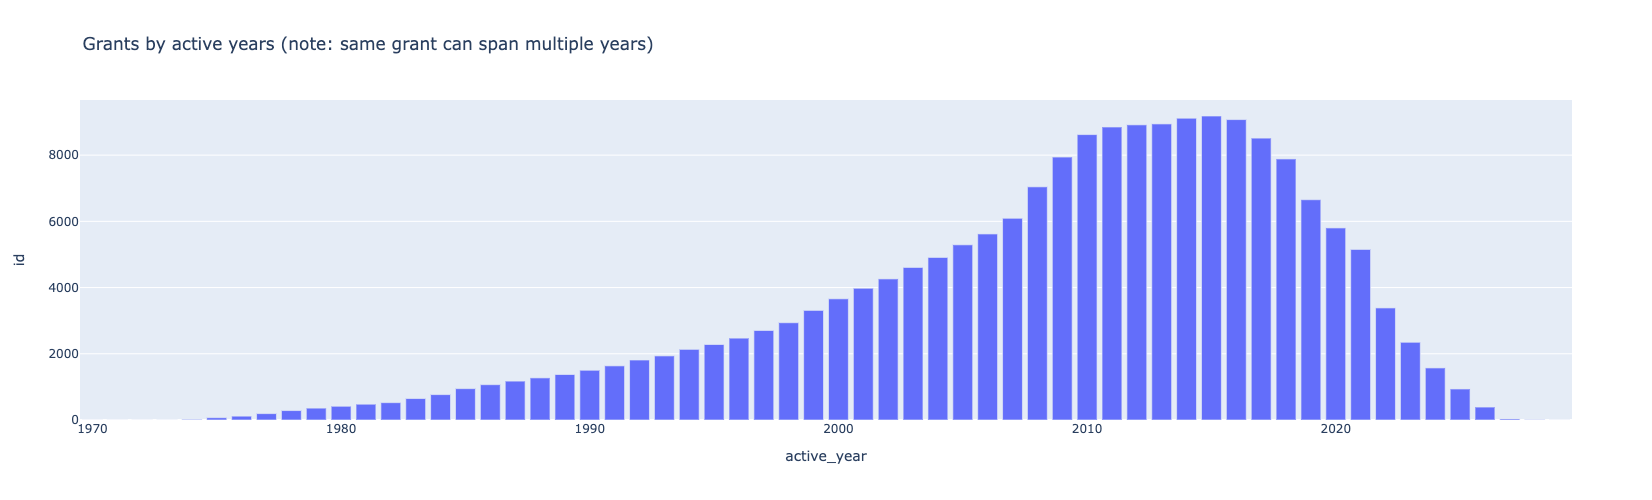

In [7]:
byyear = grants.explode('active_year')\
    .groupby(['active_year'], as_index=False)\
    .count().sort_values(by=["active_year"], ascending=True)

px.bar(byyear,
       x="active_year", y="id",
       
       height=500,
       title=f"Grants by active years (note: same grant can span multiple years)")

### Grants by funders 

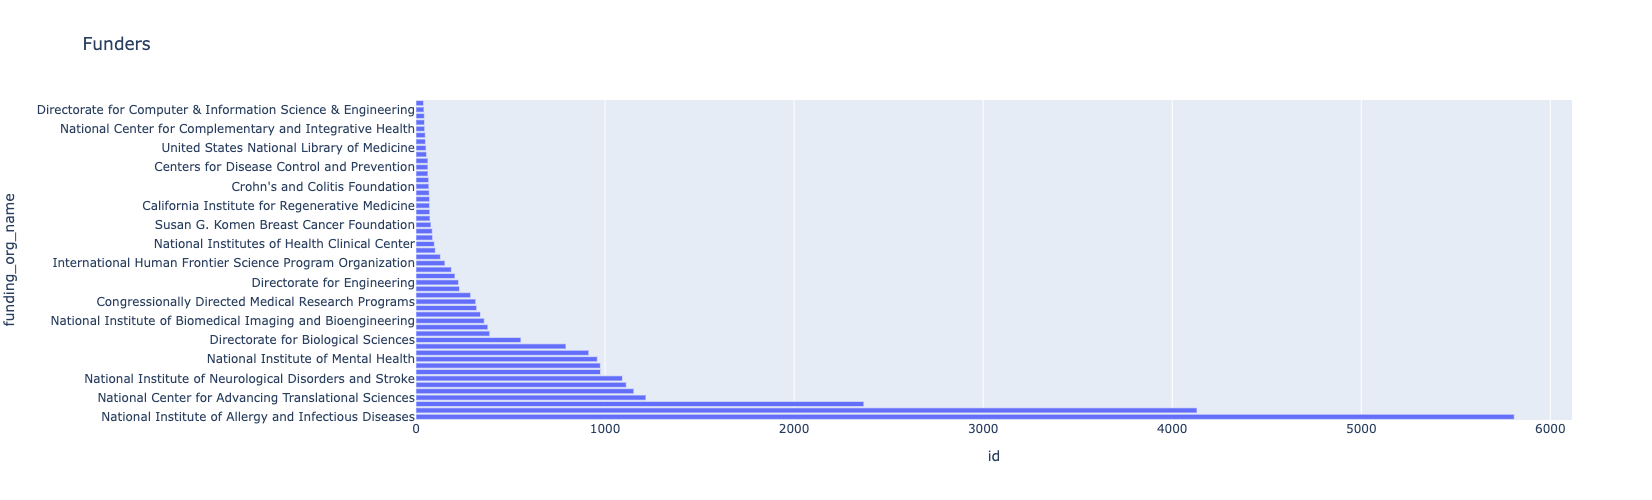

In [8]:
funders = grants\
    .groupby(['funding_org_name'], as_index=False)\
    .count().sort_values(by=["id"], ascending=False)

px.bar(funders[:50],
       x="id", y="funding_org_name",
       orientation="h",
       height=500,
       title=f"Funders")

### Funders by funding amount

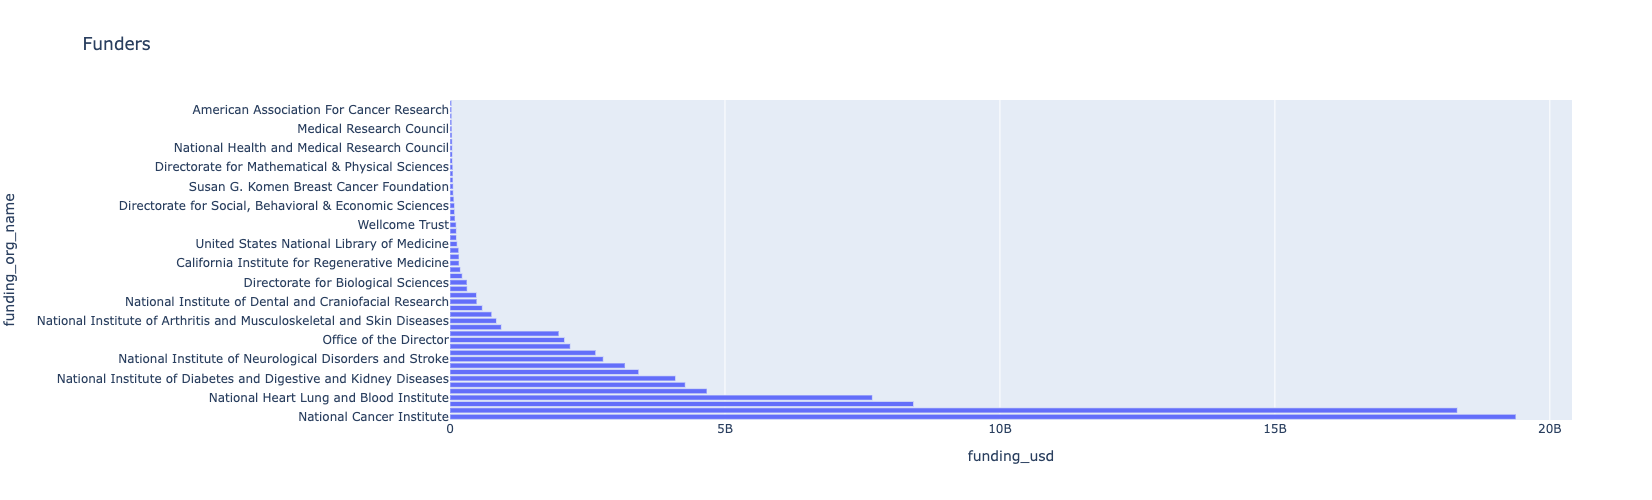

In [9]:
funders = grants\
    .groupby(['funding_org_name'], as_index=False)\
    .sum('funding_usd').sort_values(by=["funding_usd"], ascending=False)

px.bar(funders[:50],
       x="funding_usd", y="funding_org_name",
       orientation="h",
       height=500,
       title=f"Funders")
